In [148]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report
from sklearn.svm import SVC
import datetime
import pickle

In [66]:
data = pd.read_csv("smoke_detection_iot.csv")
data.sample(5)

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
9834,9834,1654743165,-3.759,55.19,831,961,12642,19525,939.146,2.22,2.31,15.30,2.386,0.054,9834,1
29907,29907,1654766256,19.850,54.58,44,400,13238,20172,939.683,2.29,2.38,15.74,2.454,0.055,4913,1
29208,29208,1654765557,22.120,48.64,91,400,13233,20124,939.653,2.19,2.27,15.06,2.349,0.053,4214,1
61890,61890,1655129312,-9.694,23.97,60000,13550,11198,16342,936.871,7168.33,8374.58,47007.70,8802.086,1073.547,5004,0
60709,60709,1655128131,13.173,39.25,0,400,13430,21390,937.406,1.51,1.57,10.39,1.621,0.037,3823,0


In [67]:
data.drop(columns=['Unnamed: 0','CNT'],inplace=True)
def extract_time(x:int):
    time = datetime.datetime.fromtimestamp(x)
    time = time.time()
    return time.hour*3600 + time.minute*60 + time.second + time.microsecond*1e-6
data['UTC'] = data['UTC'].apply(extract_time)
data.sample(5)

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
42506,65855.0,24.520,53.44,1120,401,12899,19450,938.734,1.74,1.80,11.96,1.864,0.042,1
2960,23291.0,12.093,46.03,141,400,13159,20028,939.608,0.87,0.91,6.02,0.939,0.021,0
6037,26368.0,-8.504,52.96,144,400,13186,20121,939.671,1.46,1.52,10.05,1.567,0.035,1
43243,66592.0,26.650,49.06,1203,410,12911,19420,938.698,1.99,2.07,13.73,2.141,0.048,1
58209,67031.0,-9.083,46.12,74,400,12782,20652,937.479,1.88,1.95,12.91,2.013,0.045,0


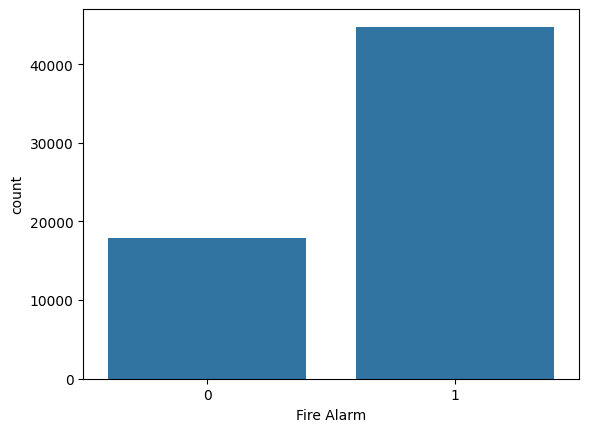

In [68]:
sns.countplot(data=data,x='Fire Alarm')
plt.show()

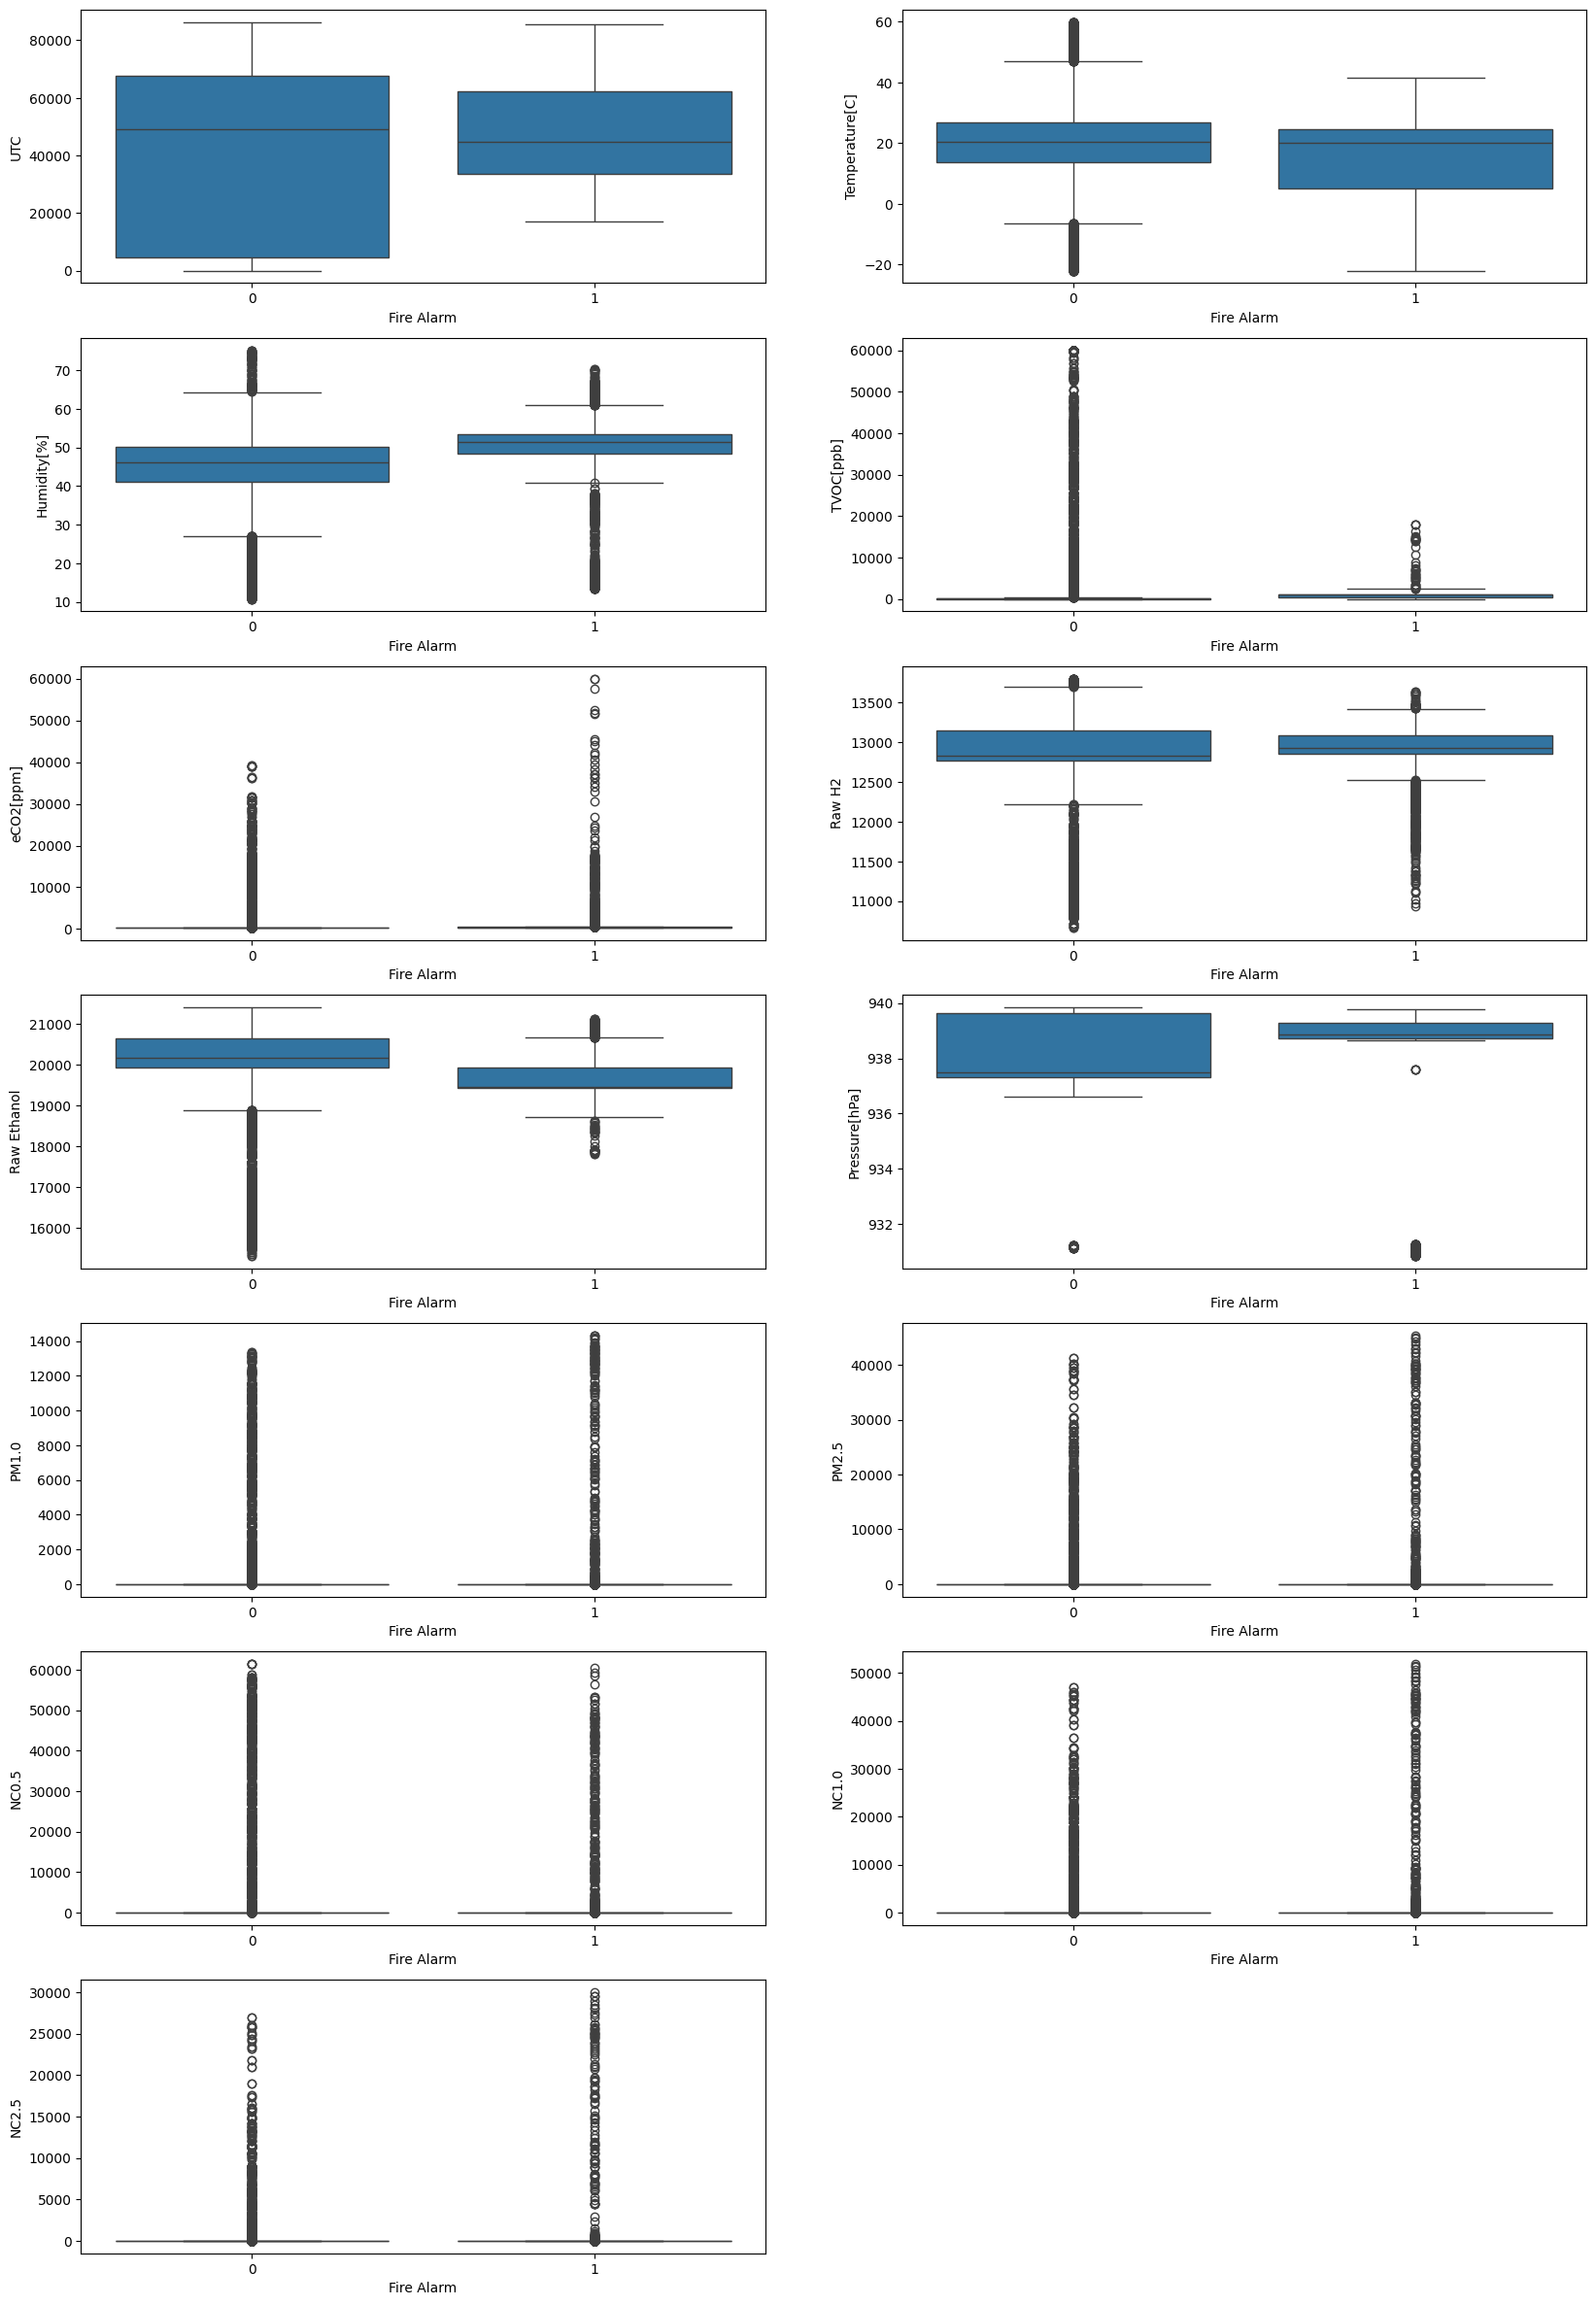

In [69]:
rows = (data.columns.shape[0]-1)//2 + (data.columns.shape[0]-1)%2
cols = 2
plt.figure(figsize=(20,30))
for i,j in enumerate(data.columns.drop('Fire Alarm')):
    plt.subplot(rows,cols,i+1)
    sns.boxplot(y=data[j],x = data['Fire Alarm'])

<Axes: >

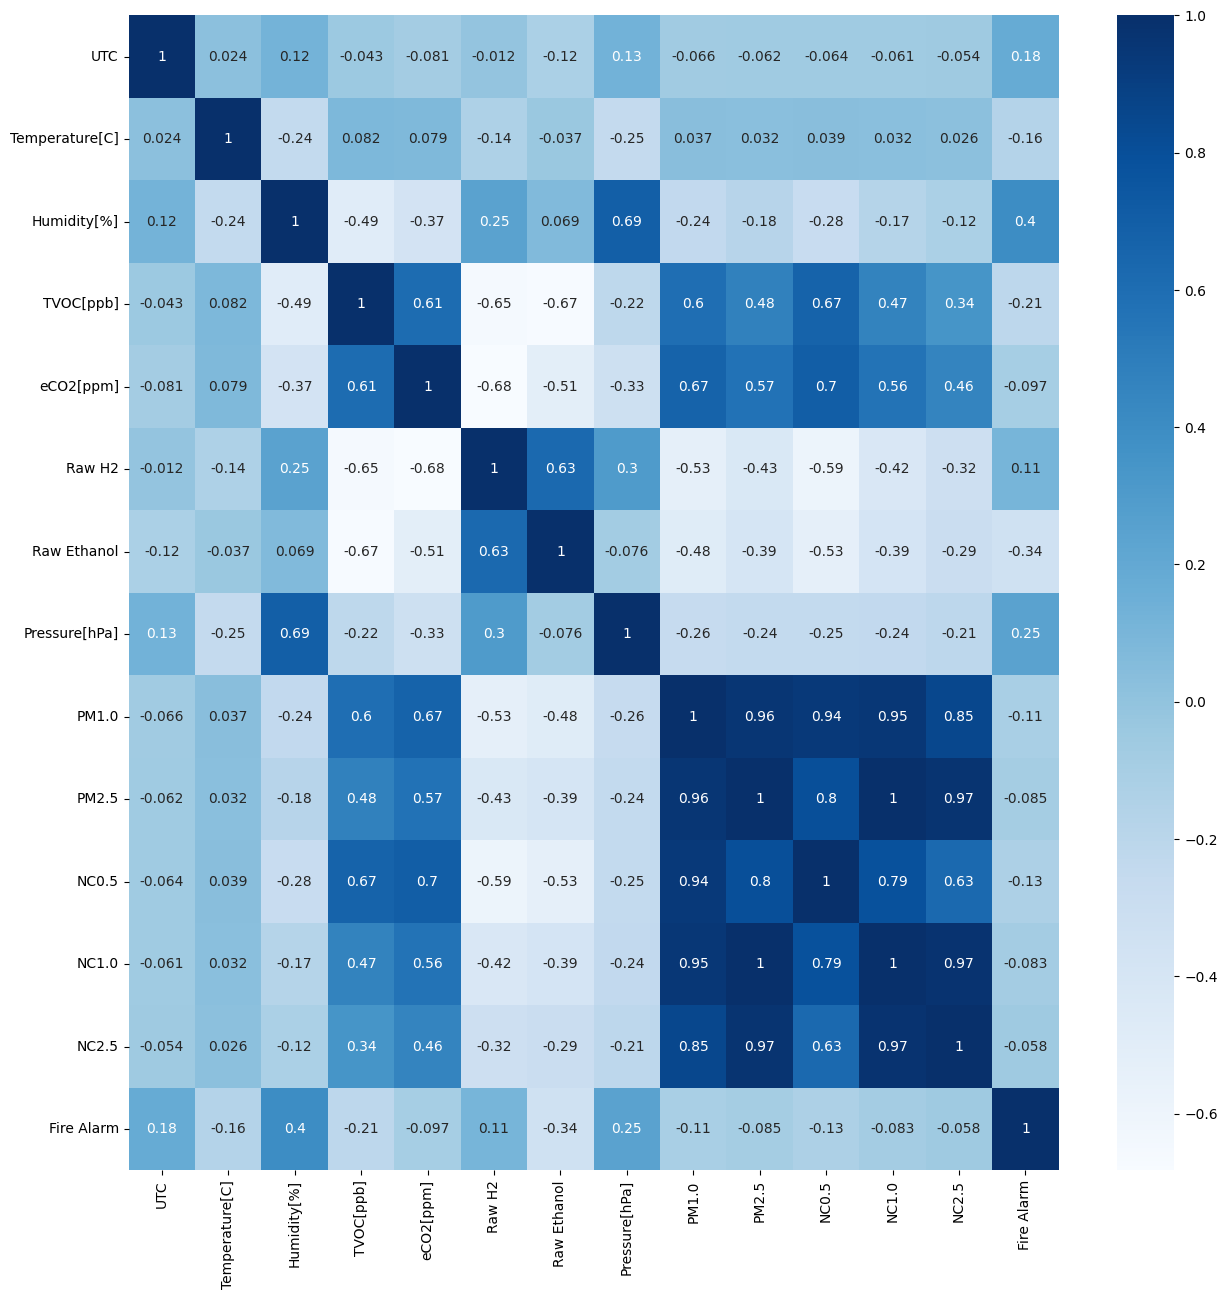

In [70]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(),annot=True,cmap="Blues")

In [71]:
temp_model = RandomForestClassifier(n_estimators=250)
temp_model.fit(data[data.columns.drop(['Fire Alarm','UTC'])].to_numpy(),data['Fire Alarm'].to_numpy())

RandomForestClassifier(n_estimators=250)

<Axes: ylabel='None'>

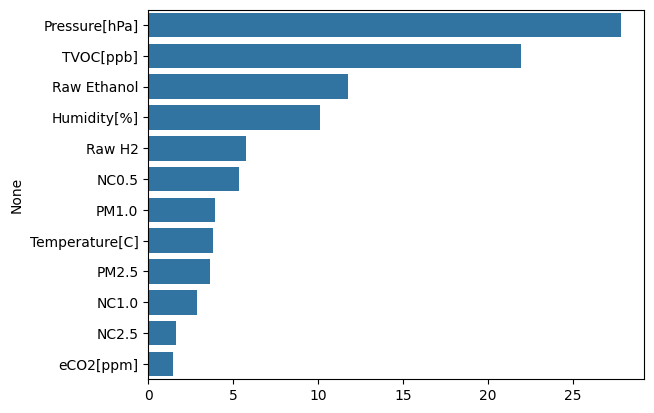

In [72]:
importance = temp_model.feature_importances_*100
order = np.argsort(importance)[::-1]
sns.barplot(x=np.sort(importance)[::-1],y=data.columns.drop(['Fire Alarm','UTC'])[order])

In [82]:
def train_model(models:list,test_x:np.ndarray,test_y:np.ndarray,train_x:np.ndarray,train_y:np.ndarray,eval:dict):
    keys = list(eval.keys())
    for i,j in enumerate(models):
        j.fit(train_x,train_y)
        pred = j.predict(test_x)
        eval[keys[i]]["precision"].append(precision_score(test_y,pred))
        eval[keys[i]]["accuracy"].append(accuracy_score(test_y,pred))
        eval[keys[i]]["recall"].append(recall_score(test_y,pred))
        eval[keys[i]]["f1"].append(f1_score(test_y,pred))
        
        

In [85]:
scalar = StandardScaler()
X = data[data.columns.drop(['Fire Alarm','UTC','NC2.5','NC1.0','PM2.5','PM1.0'])].to_numpy()
y = data['Fire Alarm'].to_numpy()
X = scalar.fit_transform(X)
skf = StratifiedKFold(n_splits=7,shuffle=True,random_state=42)
index = skf.split(X,y)
eval = {"log":{"precision":[],"recall":[],"f1":[],"accuracy":[]},"random":{"precision":[],"recall":[],"f1":[],"accuracy":[]},
        "svm":{"precision":[],"recall":[],"f1":[],"accuracy":[]},"KNN":{"precision":[],"recall":[],"f1":[],"accuracy":[]},
        "ada":{"precision":[],"recall":[],"f1":[],"accuracy":[]}, "gradient":{"precision":[],"recall":[],"f1":[],"accuracy":[]}
        }
train_models = [LogisticRegression(max_iter=1000),RandomForestClassifier(),SVC(),KNeighborsClassifier(),AdaBoostClassifier(),GradientBoostingClassifier()]
for train,test in index:
    train_model(train_models,X[test],y[test],X[train],y[train],eval)


In [89]:
summary = {
    "model":[],
    "precision":[],
    "recall":[],
    "f1_score":[],
    "accuracy":[]
}
for i in eval.keys():
    summary["model"].append(i)
    summary["precision"].append(np.mean(eval[i]["precision"]))
    summary["recall"].append(np.mean(eval[i]["recall"]))
    summary["accuracy"].append(np.mean(eval[i]["accuracy"]))
    summary["f1_score"].append(np.mean(eval[i]["f1"]))
pd.DataFrame(summary).style.background_gradient(cmap="Blues")

,model,precision,recall,f1_score,accuracy
0,log,0.907578,0.951494,0.929015,0.896088
1,random,0.999911,0.999955,0.999933,0.999904
2,svm,0.975141,0.989432,0.982234,0.974421
3,KNN,0.998794,0.999263,0.999028,0.998611
4,ada,0.999509,0.999777,0.999643,0.999489
5,gradient,0.999732,0.999866,0.999799,0.999713


In [124]:
params_grid = {
    'n_estimators':[100,150,200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features':['log2','sqrt']
}

In [129]:
model = RandomForestClassifier()
grid_search = GridSearchCV(model,param_grid=params_grid,cv=StratifiedKFold(n_splits=7) ,scoring=['recall', 'precision'],refit="recall",n_jobs=5)
grid_search.fit(X,y)

GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=5,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': ['log2', 'sqrt'],
                         'n_estimators': [100, 150, 200]},
             refit='recall', scoring=['recall', 'precision'])

In [146]:
new_skf = StratifiedKFold(n_splits=7,shuffle=True,random_state=42)
new_index = new_skf.split(X,y)
j = 1
for train,test in new_index:
    grid_search.best_estimator_.fit(X[train],y[train])
    print("Fold",j)
    print(classification_report(y[test],grid_search.best_estimator_.predict(X[test])))
    j += 1


Fold 1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2554
           1       1.00      1.00      1.00      6394

    accuracy                           1.00      8948
   macro avg       1.00      1.00      1.00      8948
weighted avg       1.00      1.00      1.00      8948

Fold 2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2554
           1       1.00      1.00      1.00      6393

    accuracy                           1.00      8947
   macro avg       1.00      1.00      1.00      8947
weighted avg       1.00      1.00      1.00      8947

Fold 3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2553
           1       1.00      1.00      1.00      6394

    accuracy                           1.00      8947
   macro avg       1.00      1.00      1.00      8947
weighted avg       1.00      1.00      1.00      8947

In [149]:
grid_search.best_estimator_.fit(X,y)

RandomForestClassifier(criterion='entropy', n_estimators=150)

In [151]:
pickle.dump(grid_search.best_estimator_,open("../model.pkl","wb"))